In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.2 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=31c8731df305f612c7bcc5f3fedfbe126cb483adff8e8c

In [ ]:
import torch


print("Runtime restarted, checking GPU...")

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Runtime restarted, checking GPU...
Fri Mar 28 14:31:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from efficientnet_pytorch import EfficientNet
from transformers import AutoModel, AutoTokenizer
import json
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_folder = "/content/drive/MyDrive/GP2/5_After_1-Image_Augmentation/Images_After_1-Image_Augmentation"
json_file = "/content/drive/MyDrive/GP2/5_After_1-Image_Augmentation/Image_1_Augmented.json"


Mounted at /content/drive


In [ ]:
import json
import os
from sklearn.model_selection import train_test_split

with open(json_file, 'r') as f:
    data = json.load(f)

label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}

patient_data = []

for entry in data:
    image_files = entry.get('MRI', []) + entry.get('TAC', [])
    image_paths = [os.path.join(image_folder, f"{img}.png") for img in image_files]

    case_text = (
        f"Title: {entry['Case']['Title']}\n"
        f"History: {entry['Case'].get('History', '')}\n"
        f"Exam: {entry['Case'].get('Exam', '')}\n"
        f"Differential Diagnosis: {entry['Case'].get('Differential Diagnosis', '')}"
    )

    location = entry.get("Location", "Unknown")

    label = entry['Class/Label']
    numeric_label = label_mapping.get(label, -1)
    patient_data.append({
        "images": image_paths,
        "text": case_text,
        "label": numeric_label,
        "location": location
    })

train_data, test_data = train_test_split(patient_data, test_size=0.2, random_state=42)

print(f"Training size: {len(train_data)}, Testing size: {len(test_data)}")
print(f"First entry: {train_data[0]}")
print(f"Label mapping: {label_mapping}")


Training size: 3785, Testing size: 947
First entry: {'images': ['/content/drive/MyDrive/GP2/5_After_1-Image_Augmentation/Images_After_1-Image_Augmentation/MPX2589_synpic16318.png'], 'text': 'Title: Microcystic meningioma\nHistory: This 59 year old woman complained of mild left arm and leg weakness poor concentration and difficulty findings words. On the day of admission, she had "blacked out" for 6 to 8 minutes.\nExam: On admission, she was awake and attentive. Her pupils were normally reactive to light and accommodation. She had a flattened left naso-labial fold and bilateral decreased hearing. The remainder of the cranial nerves were apparently normal. Strength in the left arm was graded as 4/5 and left hand grip was graded as 2/5. Reflexes were normal. Radiologic studies and subsequent surgery were performed.\nDifferential Diagnosis: â\x80¢ Metastasis â\x80¢ Anaplastic Astrocytoma â\x80¢ Anaplastic Oligodendroglioma  If extraaxial - Meningioma', 'label': 6, 'location': 'Unknown'}
La

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class MultimodalDataset(Dataset):
    def __init__(self, data, tokenizer, transform):
        self.data = data
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        images = []
        for img_path in entry['images'][:1]:
            if os.path.exists(img_path):
                try:
                    image = Image.open(img_path).convert("RGB")
                    image = self.transform(image)
                    images.append(image)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}. Skipping.")
            else:
                print(f"Warning: Missing image {img_path}, skipping.")

        if len(images) > 1:
            images = torch.stack(images)
            images = torch.mean(images, dim=0)
        elif len(images) == 1:
            images = images[0]
        else:
            print(f"Warning: No valid images for entry {idx}. Using blank image.")
            images = torch.zeros((3, 224, 224))

        tokens = self.tokenizer(
            entry["text"], padding="max_length", truncation=True, max_length=32, return_tensors="pt"
        )

        label = torch.tensor(entry["label"], dtype=torch.long)

        return images, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0), label


In [ ]:

class MultimodalModel(nn.Module):
    def __init__(self, text_model, image_model, text_embedding_size, image_embedding_size, num_classes=12):
        super(MultimodalModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model

        self.image_fc = nn.Linear(image_embedding_size, 256)

        self.fc1 = nn.Linear(256 + text_embedding_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, images, input_ids, attention_mask):

        image_features = self.image_model(images)
        image_features = self.image_fc(image_features)


        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]


        combined = torch.cat((image_features, text_features), dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [ ]:
import torch

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Fri Mar 28 14:32:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             47W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, model_name="efficientnet-b0"):
        super().__init__()
        self.model = EfficientNet.from_pretrained(model_name)
        self.model._fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

image_model = ImageFeatureExtractor().to(device).half()
print(f"After Image Model: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 152MB/s] 


Loaded pretrained weights for efficientnet-b0
After Image Model: Allocated: 0.01 GB, Cached: 0.03 GB


In [ ]:
image_model = ImageFeatureExtractor().to(device)
torch.cuda.empty_cache()
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")


text_model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})


text_model.resize_token_embeddings(len(tokenizer))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MultimodalDataset(data=train_data, tokenizer=tokenizer, transform=transform)
test_dataset = MultimodalDataset(data=test_data, tokenizer=tokenizer, transform=transform)


train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True
)


dataset = MultimodalDataset(patient_data, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

multimodal_model = MultimodalModel(
    text_model=text_model,
    image_model=image_model,
    text_embedding_size=768,
    image_embedding_size=1280,
    num_classes=12
).to(device)


optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()



Loaded pretrained weights for efficientnet-b0
GPU Memory Allocated: 0.02 GB
GPU Memory Cached: 0.04 GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

GPU Memory Allocated: 0.43 GB
GPU Memory Cached: 0.48 GB


In [ ]:
import os
file_path = "/content/drive/MyDrive/GP2/After_4-Image_Augmentation/Images_After_4-Image_Augmentation/MPX1309_synpic15871_aug_1_RR.png"

if os.path.exists(file_path):
    print("✅ File exists!")
else:
    print("❌ File is missing!")


❌ File is missing!


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

epochs = 5
torch.cuda.empty_cache()

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
for epoch in range(epochs):
    multimodal_model.train()
    running_loss = 0.0
    i=0
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = multimodal_model(images, input_ids, attention_masks)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")


    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}")

print(f"Model saved for epoch {epoch+1}")


<ipython-input-13-f44fd6cdc2af>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-13-f44fd6cdc2af>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision context


Epoch 1, Batch 1/474, Loss: 2.4780
Epoch 1, Batch 2/474, Loss: 2.5085
Epoch 1, Batch 3/474, Loss: 2.4417
Epoch 1, Batch 4/474, Loss: 2.5264
Epoch 1, Batch 5/474, Loss: 2.5386
Epoch 1, Batch 6/474, Loss: 2.4492
Epoch 1, Batch 7/474, Loss: 2.4805
Epoch 1, Batch 8/474, Loss: 2.4143
Epoch 1, Batch 9/474, Loss: 2.4778
Epoch 1, Batch 10/474, Loss: 2.5129
Epoch 1, Batch 11/474, Loss: 2.4915
Epoch 1, Batch 12/474, Loss: 2.4697
Epoch 1, Batch 13/474, Loss: 2.5288
Epoch 1, Batch 14/474, Loss: 2.5735
Epoch 1, Batch 15/474, Loss: 2.5591
Epoch 1, Batch 16/474, Loss: 2.4736
Epoch 1, Batch 17/474, Loss: 2.4602
Epoch 1, Batch 18/474, Loss: 2.5095
Epoch 1, Batch 19/474, Loss: 2.4519
Epoch 1, Batch 20/474, Loss: 2.4502
Epoch 1, Batch 21/474, Loss: 2.5308
Epoch 1, Batch 22/474, Loss: 2.5801
Epoch 1, Batch 23/474, Loss: 2.4316
Epoch 1, Batch 24/474, Loss: 2.5627
Epoch 1, Batch 25/474, Loss: 2.5056
Epoch 1, Batch 26/474, Loss: 2.4937
Epoch 1, Batch 27/474, Loss: 2.4421
Epoch 1, Batch 28/474, Loss: 2.4272
E

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
Accuracy: 0.8902

Confusion Matrix:
[[ 34   0   1   2   0   0  25   0   0   0   0   8]
 [  0  88   0   0   0   0   0   0   0   0   0   0]
 [  2   0  79   0   1   

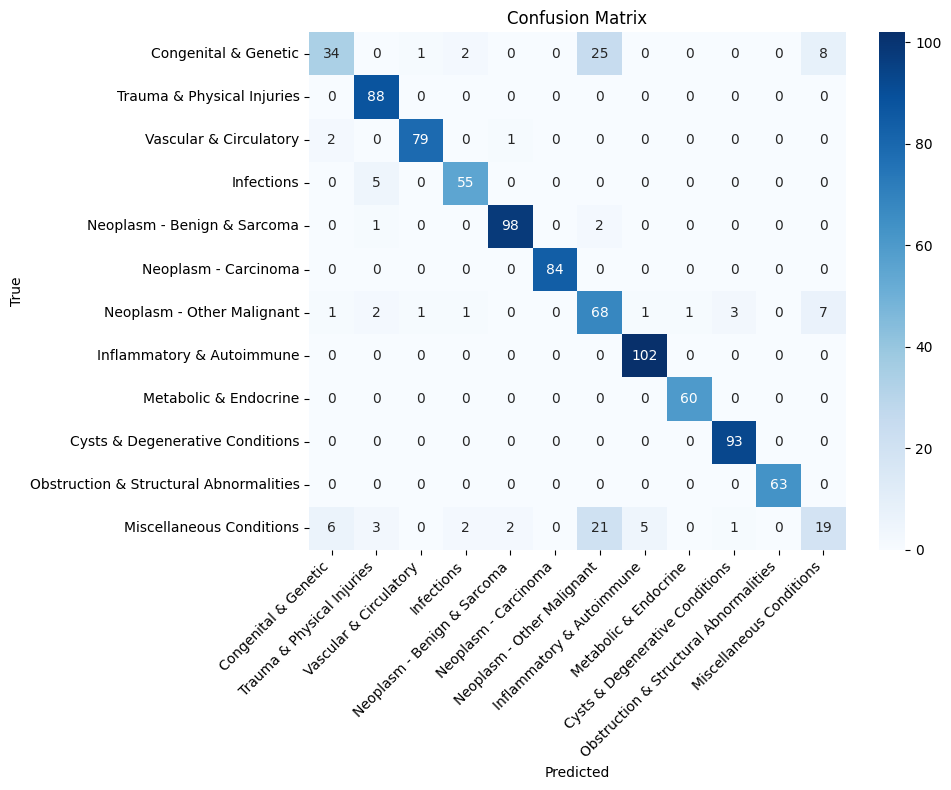

In [ ]:
multimodal_model.eval()
all_labels = []
all_preds = []
all_probs = []
i=0
with torch.no_grad():
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(test_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        print(i)
        outputs = multimodal_model(images, input_ids, attention_masks)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        i+=1
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.79      0.49      0.60        70
            Trauma & Physical Injuries       0.89      1.00      0.94        88
                Vascular & Circulatory       0.98      0.96      0.97        82
                            Infections       0.92      0.92      0.92        60
           Neoplasm - Benign & Sarcoma       0.97      0.97      0.97       101
                  Neoplasm - Carcinoma       1.00      1.00      1.00        84
            Neoplasm - Other Malignant       0.59      0.80      0.68        85
             Inflammatory & Autoimmune       0.94      1.00      0.97       102
                 Metabolic & Endocrine       0.98      1.00      0.99        60
       Cysts & Degenerative Conditions       0.96      1.00      0.98        93
Obstruction & Structural Abnormalities       1.00      1.00      1.00        63
              M

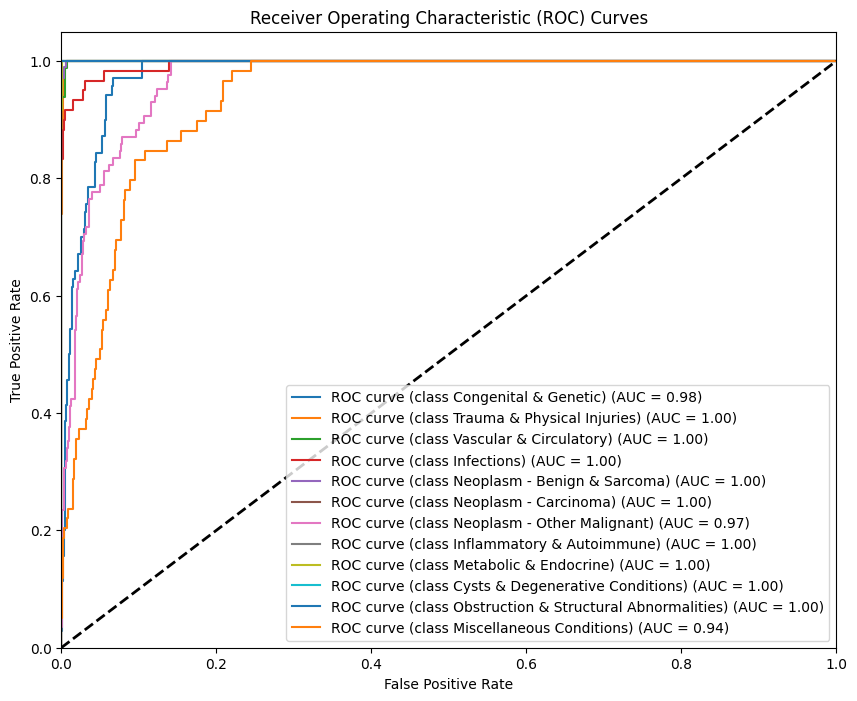


AUC-ROC for each class:
Class Congenital & Genetic: 0.9790
Class Trauma & Physical Injuries: 0.9995
Class Vascular & Circulatory: 0.9997
Class Infections: 0.9953
Class Neoplasm - Benign & Sarcoma: 0.9998
Class Neoplasm - Carcinoma: 1.0000
Class Neoplasm - Other Malignant: 0.9681
Class Inflammatory & Autoimmune: 1.0000
Class Metabolic & Endocrine: 0.9999
Class Cysts & Degenerative Conditions: 1.0000
Class Obstruction & Structural Abnormalities: 1.0000
Class Miscellaneous Conditions: 0.9374


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(key) for key in label_mapping.keys()]))

from sklearn.preprocessing import label_binarize
num_classes = len(label_mapping)
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-Average AUC-ROC: {macro_roc_auc:.4f}")

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {list(label_mapping.keys())[i]}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

print("\nAUC-ROC for each class:")
for i, class_name in enumerate(label_mapping.keys()):
    print(f"Class {class_name}: {roc_auc[i]:.4f}")

In [ ]:
multimodal_model.eval()

correct_predictions = 0
total_samples = 0
running_loss = 0.0

with torch.no_grad():
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, input_ids, attention_masks)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

epoch_loss = running_loss / len(train_dataloader)
epoch_accuracy = correct_predictions / total_samples * 100

print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")


Training Loss: 0.2064, Training Accuracy: 92.92%
